In [ ]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats
from scipy import ndimage # HCSR metric

import random
import cv2
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
low_freq_images = '/content/drive/MyDrive/Resized Low Ultrasound Images'
print(len(low_freq_images))
high_freq_images = '/content/drive/MyDrive/Resized High Ultrasound Images'
print(len(high_freq_images))

1000
1000


# Generate with "Image augmentation"

In [ ]:
# image Augmentation

def augment_image(image):
  transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, scale=(0.99, 1.01)),
    transforms.ElasticTransform(alpha=0.5, sigma=0.1),
    transforms.RandomResizedCrop(size=image.size, scale=(0.95, 1.05)),
    transforms.RandomAdjustSharpness(sharpness_factor=1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))
  ])
  return transform(image)

def generate_augmented_images(images, num_augmentations):
  augmented_images = []
  for img in images:
    pil_img = Image.fromarray((img).astype(np.uint8))
    for _ in range(num_augmentations):
      augmented_img = augment_image(pil_img)
      augmented_images.append(np.array(augmented_img))
  return augmented_images

augmented_low_freq = generate_augmented_images(low_freq_images, num_augmentations=1) # one augemented images for each original image
print(len(augmented_low_freq))
augmented_high_freq = generate_augmented_images(high_freq_images, num_augmentations=1)
print(len(augmented_high_freq))

1000
1000


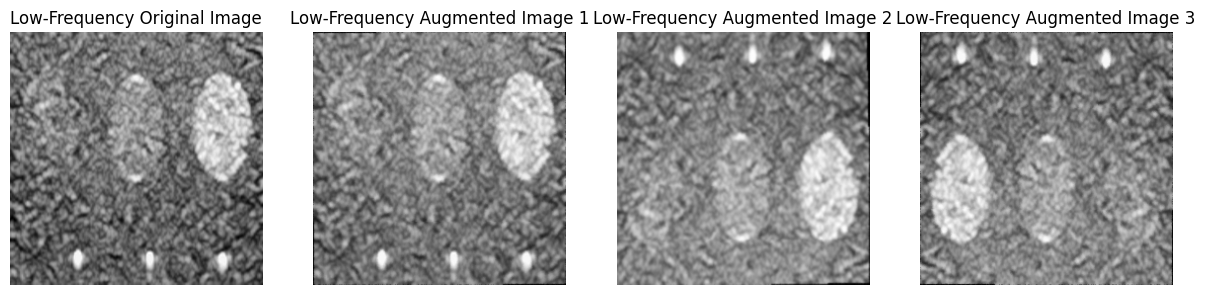

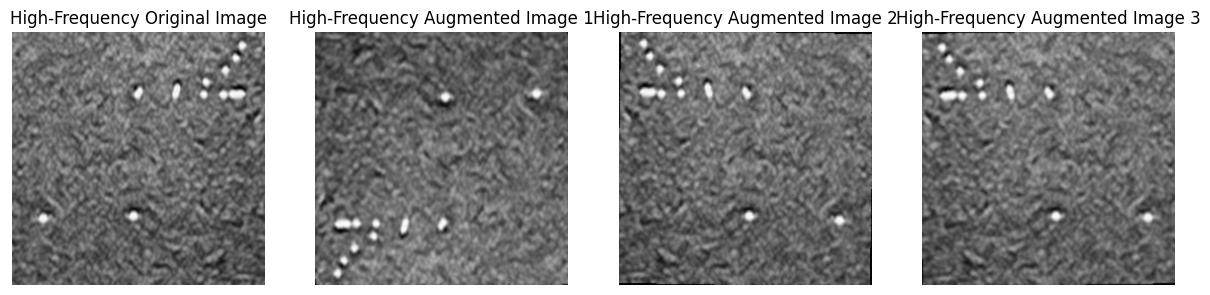

In [ ]:
# plot augmented images

def plot_side_by_side(original_image, augmented_images, title_prefix=""):
  num_images = len(augmented_images) + 1  # +1 for the original image
  plt.figure(figsize=(15, 5))

  # plot the original image
  plt.subplot(1, num_images, 1)
  plt.imshow(original_image.squeeze(), cmap='gray')
  plt.title(f"{title_prefix}Original Image")
  plt.axis('off')

  # Plot augmented images
  for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, num_images, i+2)
    plt.imshow(aug_img.squeeze(), cmap='gray')
    plt.title(f"{title_prefix}Augmented Image {i+1}")
    plt.axis('off')

  plt.show()

original_low = low_freq_images[0]  # first original low-frequency image
augmented_low = generate_augmented_images([original_low], num_augmentations=3)  # generate 3 augmentations
original_high = high_freq_images[0]  # first original high-frequency image
augmented_high = generate_augmented_images([original_high], num_augmentations=3)  # generate 3 augmentations

plot_side_by_side(original_low, augmented_low, title_prefix="Low-Frequency ")
plot_side_by_side(original_high, augmented_high, title_prefix="High-Frequency ")

In [ ]:
# image assessing (we assessed with only metrics that didn't need a reference image)

def calculate_metrics(images):
  metrics_data = {
      'SNR': [],
      'CNR': [],
      'HCSR': [],
  }

  for img in images:
    img_flat = img.flatten()

    # Signal-to-Noise Ratio (SNR)
    signal = np.mean(img_flat)
    noise = np.std(img_flat)
    snr = signal / noise if noise != 0 else float('inf')

    # Contrast-to-Noise Ratio (CNR)
    contrast = np.max(img_flat) - np.min(img_flat)
    cnr = contrast / noise if noise != 0 else float('inf')

    # High-Contrast Spatial Resolution (HCSR)
    edges = ndimage.sobel(img)
    hcsr = np.mean(edges) / np.mean(np.abs(img)) if np.mean(np.abs(img)) != 0 else float('inf')

    # Append metrics to corresponding lists
    metrics_data['SNR'].append(snr)
    metrics_data['CNR'].append(cnr)
    metrics_data['HCSR'].append(hcsr)

  return metrics_data

# calculate metrics
original_low_freq_metrics = calculate_metrics(low_freq_images)
augmented_low_freq_metrics = calculate_metrics(augmented_low_freq)
original_high_freq_metrics = calculate_metrics(high_freq_images)
augmented_high_freq_metrics = calculate_metrics(augmented_high_freq)

original_low_freq_metrics = pd.DataFrame(original_low_freq_metrics)
augmented_low_freq_metrics = pd.DataFrame(augmented_low_freq_metrics)
original_high_freq_metrics = pd.DataFrame(original_high_freq_metrics)
augmented_high_freq_metrics = pd.DataFrame(augmented_high_freq_metrics)

def display_average_metrics(df, group_name):
  print(f"Average values for each metric in {group_name}:")
  for metric in df.columns:
    average_value = df[metric].mean()
    print(f"{metric}: {average_value:.4f}")

# display average values for Low-Frequency and High-Frequency Groups
display_average_metrics(original_low_freq_metrics, "Low-Frequency (original)")
display_average_metrics(augmented_low_freq_metrics, "Low-Frequency (augmented)")
display_average_metrics(original_high_freq_metrics, "High-Frequency (original)")
display_average_metrics(augmented_high_freq_metrics, "High-Frequency (Augmented)")

Average values for each metric in Low-Frequency (original):
SNR: 3.0075
CNR: 7.3009
HCSR: 1.7030
Average values for each metric in Low-Frequency (augmented):
SNR: 3.0909
CNR: 7.3563
HCSR: 1.7104
Average values for each metric in High-Frequency (original):
SNR: 2.5344
CNR: 7.9319
HCSR: 2.6688
Average values for each metric in High-Frequency (Augmented):
SNR: 2.6409
CNR: 7.9640
HCSR: 2.6859


In [ ]:
# compare with original

for metric in original_low_freq_metrics.keys():
  t_stat, p_value = stats.ttest_ind(original_low_freq_metrics[metric], augmented_low_freq_metrics[metric], equal_var=False)
  print("Low frequency:")
  print(f"T-test for {metric}:")
  print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}\n")

for metric in original_high_freq_metrics.keys():
  t_stat, p_value = stats.ttest_ind(original_high_freq_metrics[metric], augmented_high_freq_metrics[metric])
  print("High frequency:")
  print(f"T-test for {metric}:")
  print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}\n")

Low frequency:
T-test for SNR:
T-statistic: -2.10, P-value: 0.036

Low frequency:
T-test for CNR:
T-statistic: -1.19, P-value: 0.236

Low frequency:
T-test for HCSR:
T-statistic: -0.28, P-value: 0.780

High frequency:
T-test for SNR:
T-statistic: -2.22, P-value: 0.027

High frequency:
T-test for CNR:
T-statistic: -0.45, P-value: 0.652

High frequency:
T-test for HCSR:
T-statistic: -0.20, P-value: 0.843

